In [1]:
!pip install antigranular

In [2]:
import antigranular as ag
session = ag.login(<client_id>,<client_secret>, dataset = "Iris Dataset")

Connected to Antigranular server session id: 177f5b99-073c-428f-8a9a-cc71e9b97808
Cell magic '%%ag' registered successfully, use `%%ag` in a notebook cell to execute your python code on Antigranular private python server


In [3]:
%%ag
from op_pandas import PrivateDataFrame , PrivateSeries
from ag_utils import load_dataset, export

response = load_dataset("Iris Dataset")   # loading the Iris Dataset

train_x = response["train_x"]
train_y = response["train_y"]
test_x = response["test_x"]

### How the columns look like

In [4]:
%%ag
export(train_x.columns, "columns")  # Exporting the columns to get the name of the columns

Setting up exported variable in local environment: columns


In [5]:
columns     # Exported variables can be accessed locally

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], dtype='object')

In [6]:
session.privacy_odometer()

{'total_epsilon_used': 0.0, 'total_delta_used': 0.0}

In [7]:
%%ag
hist2d = train_x.hist2d(1, 'sepal_length', 'sepal_width')       # creating a differentially private 2-d histogram of sepal_length and sepal_width
export(hist2d, 'hist2d')

Setting up exported variable in local environment: hist2d


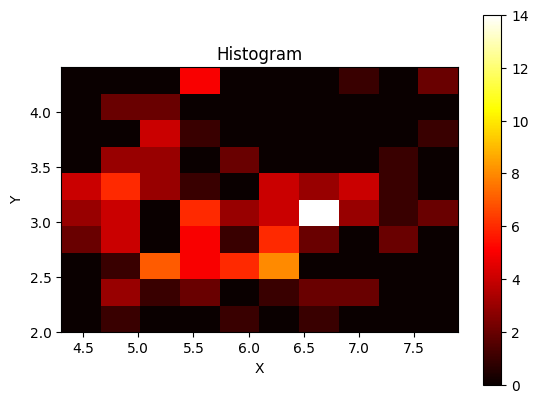

In [8]:
import matplotlib.pyplot as plt       # plotting the 2-d histogram as a heatmap
hist, x_edges, y_edges = hist2d
plt.imshow(hist.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], cmap='hot')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Histogram')
plt.show()

In [9]:
%%ag
hist2d = train_x.hist2d(1, 'petal_length', 'petal_width')     # Similar histogram for petal_length and petal_width
export(hist2d, 'hist2d_petal')

Setting up exported variable in local environment: hist2d_petal


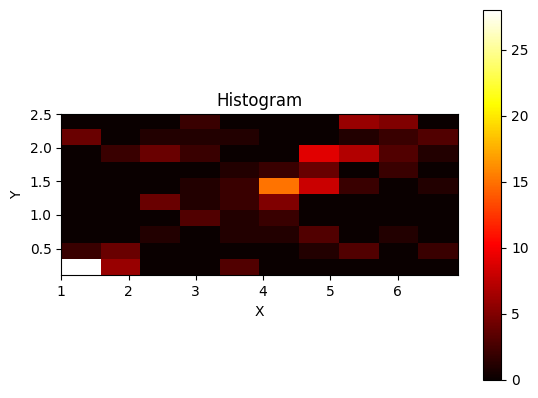

In [10]:
import matplotlib.pyplot as plt         # plotting the 2-d histogram as a heatmap
hist, x_edges, y_edges = hist2d_petal
plt.imshow(hist.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], cmap='hot')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Histogram')
plt.show()

In [11]:
%%ag
export(train_x.describe(eps = 1), "describe")     #  Exporting the describe of the dataset

Total epsilon spent = 1.0000

Setting up exported variable in local environment: describe


In [12]:
describe

,sepal_length,sepal_width,petal_length,petal_width
count,74.000000,74.000000,74.000000,74.000000
mean,6.317271,2.510459,5.498123,2.321605
std,0.477956,0.689204,1.985927,0.874557
min,4.462524,2.493148,2.574322,0.958551
25%,5.951697,2.086348,1.386443,1.442809
50%,5.436382,3.279005,2.076844,1.309862
75%,7.498336,3.684863,2.385437,2.010885
max,6.346734,4.048501,5.335383,1.432338


## Encoding train_y

In [13]:
%%ag
from typing import Any
# encoding categoricals
def func_(x:str)-> int:
  if x == 'Iris-setosa':
    return 0
  elif x == 'Iris-versicolor':
    return 1
  else: # Iris-virginica
    return 2

train_y_encoded = train_y.applymap(func_ , output_bounds={'species':(0,2)})     # applymap with output_bounds doesnt require epsilon

## Logistic Regression


In [14]:
%%ag
from op_diffprivlib.models import LogisticRegression      # using logistic regression to predict

In [15]:
%%ag
# Finding the l2 norm, which is necessary for Logistic Regression
train_x_2 = train_x ** 2
l_2_norm = train_x_2.sum(axis = 1) ** 0.5
l_2_norm = l_2_norm.quantile(1, eps=1)    # dp_max(sum(x**2, 1)**0.5)

In [16]:
%%ag
# Fitting the model
logr = LogisticRegression(epsilon = 10, data_norm = l_2_norm)
logr.fit(train_x, train_y_encoded)
test_y = logr.predict(test_x)

/usr/local/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



In [17]:
%%ag
# export the prediction
export(test_y, "test_y")

Setting up exported variable in local environment: test_y


In [18]:
test_y

array([1, 0, 1, 2, 1, 0, 2, 2, 1, 1, 2, 1, 0, 1, 0, 0, 2, 1, 1, 2, 1, 2,
       2, 2, 0, 2, 1, 2, 2, 1])

In [19]:
# Mapping them back to strings
def func_(x: int)-> str:
  if x == 0:
    return 'Iris-setosa'
  elif x == 1:
    return 'Iris-versicolor'
  else:
    return 'Iris-virginica'

test_y = [func_(x) for x in test_y]

In [20]:
test_y

['Iris-versicolor',
 'Iris-setosa',
 'Iris-versicolor',
 'Iris-virginica',
 'Iris-versicolor',
 'Iris-setosa',
 'Iris-virginica',
 'Iris-virginica',
 'Iris-versicolor',
 'Iris-versicolor',
 'Iris-virginica',
 'Iris-versicolor',
 'Iris-setosa',
 'Iris-versicolor',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-virginica',
 'Iris-versicolor',
 'Iris-versicolor',
 'Iris-virginica',
 'Iris-versicolor',
 'Iris-virginica',
 'Iris-virginica',
 'Iris-virginica',
 'Iris-setosa',
 'Iris-virginica',
 'Iris-versicolor',
 'Iris-virginica',
 'Iris-virginica',
 'Iris-versicolor']

In [21]:
import pandas as pd
# checking the metrics
y_df = pd.DataFrame(test_y)
result = session.submit_predictions(y_df)
print(result)

{'score': {'leaderboard': 1.0, 'logs': {'BIN_ACC': 1.0}}}
